## Семинар 2 "Распознавание рукописных цифр"

ФИО: Кузнецова Мария Павловна

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [38]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
from IPython.display import clear_output
%matplotlib inline

In [83]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [84]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

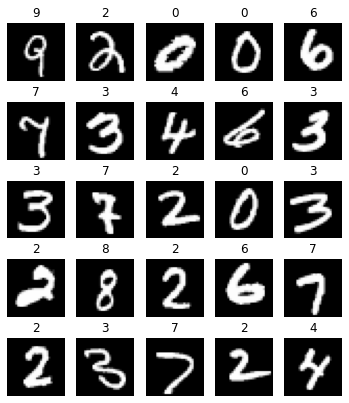

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [9]:
def train(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [10]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

In [ ]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01)

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [22]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass

In [ ]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.037/0.082	Accuracy: 0.990/0.976

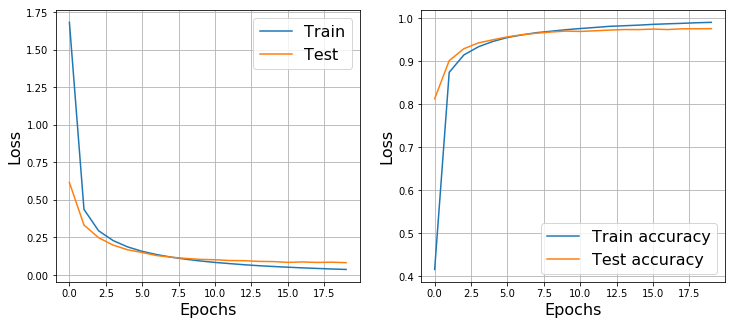

In [ ]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, 0.01, plot=True, verbose=True)

Epoch 19... (Train/Test) NLL: 0.046/0.079	Accuracy: 0.987/0.976

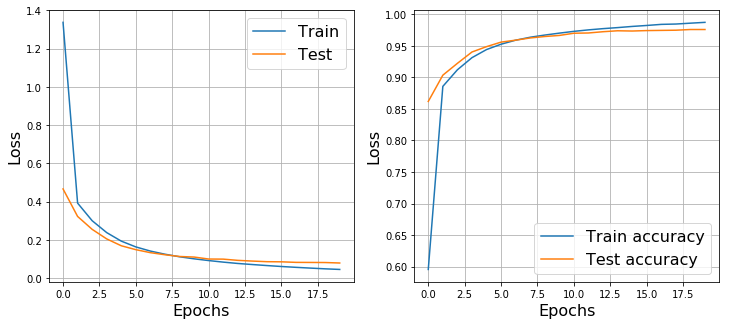

In [ ]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)

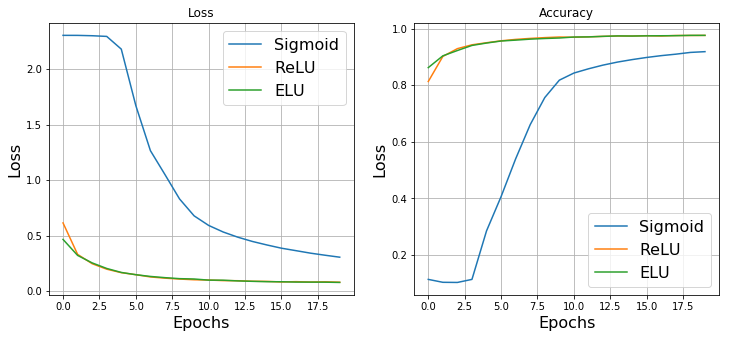

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### HW1 (1 балл): Реализовать Tanh

In [13]:
class Tanh:
    def __init__(self):
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.exp = np.exp(2 * X)
        return 1 - 2 / (self.exp + 1)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        dLdx = 4 * dLdy * self.exp / (self.exp + 1)**2
        
        return dLdx
    
    def step(self, learning_rate):
        pass

In [18]:
network = NeuralNetwork([
    Linear(784, 100), Tanh(), # 28 * 28
    Linear(100, 100), Tanh(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.032/0.079	Accuracy: 0.993/0.976

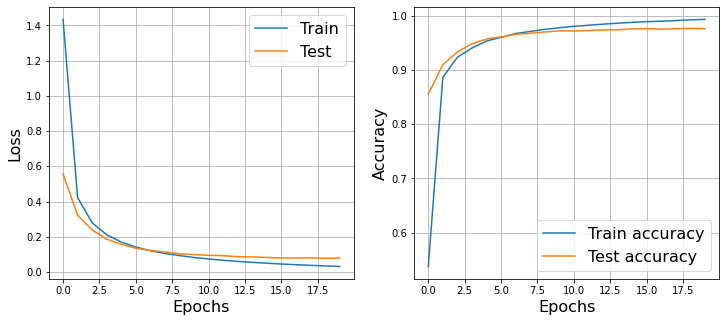

In [19]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01)

### Часть 3: Анализ ошибок

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [59]:
from skimage.transform import rotate

transform_rotation = transforms.Compose([
                       transforms.Lambda(lambda x: rotate(np.array(x), np.random.randint(-15, 15))),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset_rotation = MNIST('.', train=True, download=True, transform=transform_rotation)
test_dataset_rotation = MNIST('.', train=False, transform=transform_rotation)

train_loader = DataLoader(train_dataset_rotation, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset_rotation, batch_size=32, shuffle=False)

network = NeuralNetwork([
    Linear(784, 100), ReLU(), 
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.068/0.083	Accuracy: 0.979/0.974

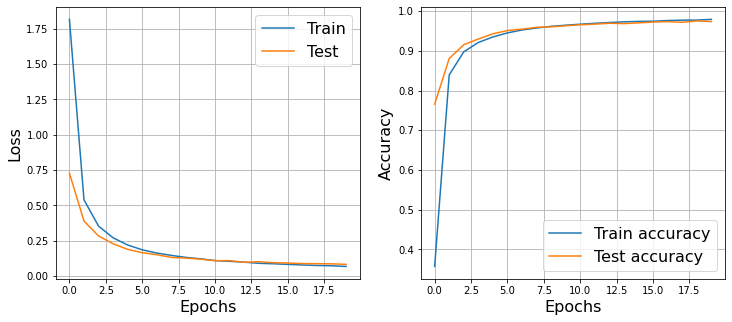

In [60]:
tr_rotation, ts_rotation, tr_ac_rotation, ts_ac_rotation = train(network, 20, 0.01, plot=True, verbose=True)

In [110]:
from skimage import transform

def shifts(x):
      tform = transform.SimilarityTransform(translation=np.random.randn(1, 2))
    return transform.warp(np.array(x), tform)

In [111]:
from skimage.transform import AffineTransform

transform_shifts = transforms.Compose([
                       transforms.Lambda(shifts),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset_shifts = MNIST('.', train=True, download=True, transform=transform_shifts)
test_dataset_shifts = MNIST('.', train=False, transform=transform_shifts)

train_loader = DataLoader(train_dataset_shifts, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset_shifts, batch_size=32, shuffle=False)

network = NeuralNetwork([
    Linear(784, 100), ReLU(), 
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.092/0.091	Accuracy: 0.973/0.972

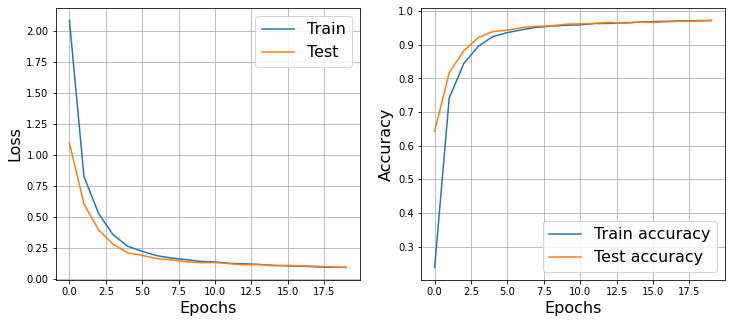

In [112]:
tr_shifts, ts_shifts, tr_ac_shifts, ts_ac_shifts = train(network, 20, 0.01, plot=True, verbose=True)

In [76]:
from torch import randn_like
transform_noise = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Lambda(lambda x: x + randn_like(x)*0.1),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset_noise = MNIST('.', train=True, download=True, transform=transform_noise)
test_dataset_noise = MNIST('.', train=False, transform=transform_noise)

train_loader = DataLoader(train_dataset_noise, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset_noise, batch_size=32, shuffle=False)

network = NeuralNetwork([
    Linear(784, 100), ReLU(), 
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.045/0.084	Accuracy: 0.986/0.975

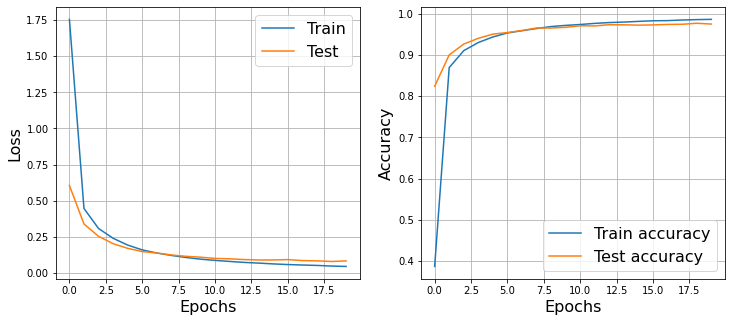

In [77]:
tr_noise, ts_noise, tr_ac_noise, ts_ac_noise = train(network, 20, 0.01, plot=True, verbose=True)

In [113]:
transform_all = transforms.Compose([
                       transforms.Lambda(lambda x: rotate(np.array(x), np.random.randint(-15, 15))),
                       transforms.Lambda(shifts),
                       transforms.ToTensor(),
                       transforms.Lambda(lambda x: x + randn_like(x)*0.1),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset_all = MNIST('.', train=True, download=True, transform=transform_all)
test_dataset_all = MNIST('.', train=False, transform=transform_all)

train_loader = DataLoader(train_dataset_all, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset_all, batch_size=32, shuffle=False)

network = NeuralNetwork([
    Linear(784, 100), ReLU(), 
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.118/0.117	Accuracy: 0.964/0.965

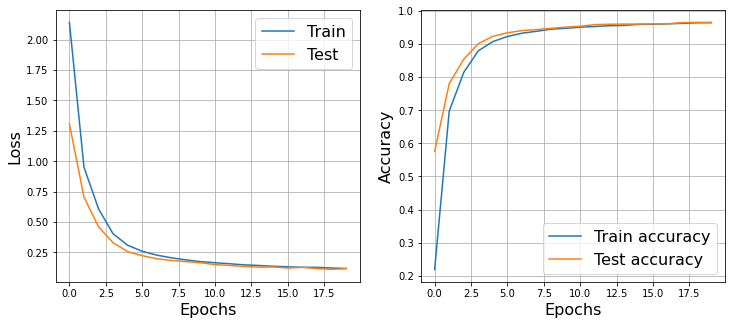

In [114]:
tr_all, ts_all, tr_ac_all, ts_ac_all = train(network, 20, 0.01, plot=True, verbose=True)

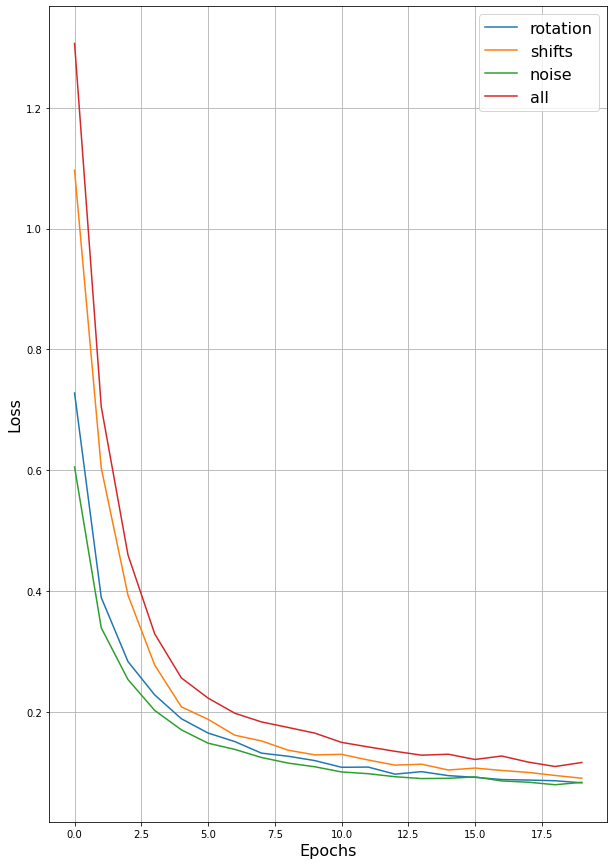

In [115]:
plt.figure(figsize=(10, 15))
plt.plot(ts_rotation, label='rotation')
plt.plot(ts_shifts, label='shifts')
plt.plot(ts_noise, label='noise')
plt.plot(ts_all, label='all')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

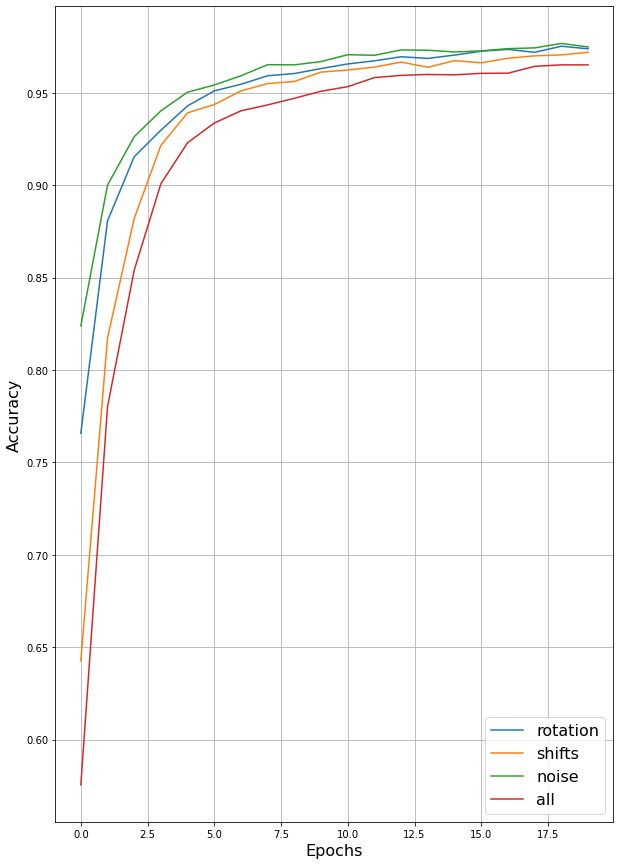

In [116]:
plt.figure(figsize=(10, 15))
plt.plot(ts_ac_rotation, label='rotation')
plt.plot(ts_ac_shifts, label='shifts')
plt.plot(ts_ac_noise, label='noise')
plt.plot(ts_ac_all, label='all')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

Быстрее всех сходимость при использовании Tanh. ReLU и ELU показывают примерно одинаковую скорость сходимости, чуть хуже чем при Tanh. С сигмоидой сходимость медленнее всего.

Сдвиги, повороты и шум показывают хорошее качество. А модель со всеми видам изменений показывает качество немного хуже, хотя это и неудивительно, исходная картинка претерпевает достаточно много изменений.